In [97]:
import pandas as pd
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)
import numpy as np
from utils import peek
import joblib
import pickle
import config

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgbm
import sklearn

from functools import partial
from scipy.optimize import fmin

In [98]:
train = pd.read_csv(config.TRAIN3)
train_x, train_y = train.drop(['order_status_key', 'customer_phone', 'fold'], axis=1), train['order_status_key']

In [99]:
clf = lgbm.Booster(model_file=config.LIGHTGBM)
train['score'] = clf.predict(train_x)

In [17]:
pos_wrong = train.query('order_status_key == 1').sort_values('score')[:30]

In [18]:
neg_wrong = train.query('order_status_key == 0').sort_values('score', ascending=False)[:70]

In [19]:
wrong = pd.concat([pos_wrong, neg_wrong])

In [22]:
wrong.to_excel("../data/error_samples.xlsx", index=False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

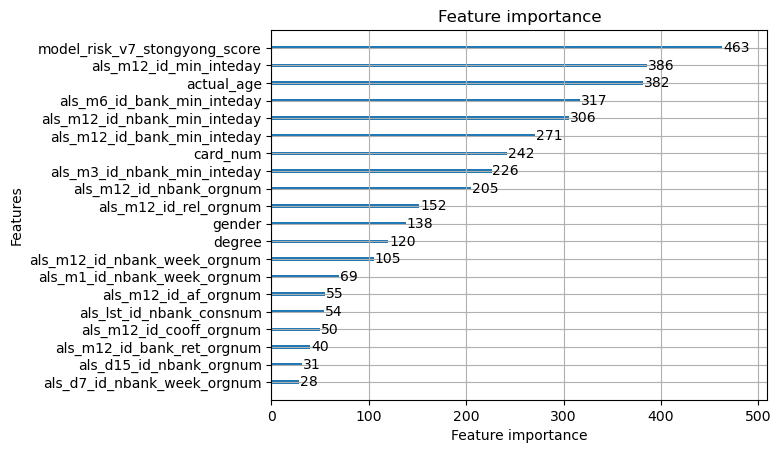

In [20]:
lgbm.plot_importance(clf)

In [62]:
train.query('order_status_key == 1')[['model_risk_v7_stongyong_score', 'omriskscoregeneral']].describe()

,model_risk_v7_stongyong_score,omriskscoregeneral
count,1427.000000,1427.000000
mean,30.716188,728.392432
std,14.867957,83.469516
min,4.000000,459.000000
25%,19.000000,667.000000
50%,29.000000,730.000000
75%,40.000000,790.000000
max,81.000000,900.000000


In [26]:
train.columns

Index(['model_risk_v7_stongyong_score', 'als_m12_id_nbank_orgnum',
       'als_m12_id_nbank_min_inteday', 'als_m12_id_min_inteday',
       'als_m3_id_nbank_min_inteday', 'als_m12_id_nbank_week_orgnum',
       'als_lst_id_nbank_consnum', 'als_d15_id_nbank_orgnum',
       'als_m1_id_nbank_week_orgnum', 'als_m12_id_rel_orgnum',
       'als_m6_id_bank_min_inteday', 'als_d7_id_nbank_week_orgnum',
       'als_m12_id_cooff_orgnum', 'als_m12_id_bank_min_inteday',
       'als_m12_id_bank_ret_orgnum', 'als_m12_id_af_orgnum', 'actual_age',
       'gender', 'degree', 'card_num', 'order_status_key', 'fold', 'score'],
      dtype='object')

In [31]:
use_cols = ['customer_phone', 'model_risk_v7_stongyong_score', 'als_m12_id_nbank_orgnum',
       'als_m12_id_nbank_min_inteday', 'als_m12_id_min_inteday',
       'als_m3_id_nbank_min_inteday', 'als_m12_id_nbank_week_orgnum',
       'als_lst_id_nbank_consnum', 'als_d15_id_nbank_orgnum',
       'als_m1_id_nbank_week_orgnum', 'als_m12_id_rel_orgnum',
       'als_m6_id_bank_min_inteday', 'als_d7_id_nbank_week_orgnum',
       'als_m12_id_cooff_orgnum', 'als_m12_id_bank_min_inteday',
       'als_m12_id_bank_ret_orgnum', 'als_m12_id_af_orgnum', 'actual_age',
       'gender', 'degree', 'card_num', 'order_status_key']
data = pd.read_csv(config.DATA)[use_cols]

In [64]:
data.query('model_risk_v7_stongyong_score == 15 & als_m12_id_nbank_min_inteday == 101')

,customer_phone,model_risk_v7_stongyong_score,als_m12_id_nbank_orgnum,als_m12_id_nbank_min_inteday,als_m12_id_min_inteday,als_m3_id_nbank_min_inteday,als_m12_id_nbank_week_orgnum,als_lst_id_nbank_consnum,als_d15_id_nbank_orgnum,als_m1_id_nbank_week_orgnum,als_m12_id_rel_orgnum,als_m6_id_bank_min_inteday,als_d7_id_nbank_week_orgnum,als_m12_id_cooff_orgnum,als_m12_id_bank_min_inteday,als_m12_id_bank_ret_orgnum,als_m12_id_af_orgnum,actual_age,gender,degree,card_num,order_status_key
7391,50f5fda87d131f0a019e58c435deb27c,15.0,1.0,101.0,5.0,-9999.0,1.0,1.0,0.0,-9999.0,1.0,31.0,-9999.0,0.0,31.0,0.0,0.0,33.0,male,大学专科,1张,2


In [30]:
br_duotou = pd.read_csv("/sda/huweipeng/project/长安银行/data/third_party_data/百融数据/样本量10000/详细匹配数据及字典/借贷意向验证-V2.0.csv", header=1, parse_dates=['申请日期'])
customer = pd.read_csv("/sda/huweipeng/project/长安银行/data/third_party_data/百融数据/百融样本.csv", parse_dates=['申请日期'])
br_duotou['customer_phone'] = customer['手机号']
br_duotou = br_duotou[br_duotou['产品输出标识'] == 1]

In [71]:
br_duotou.query('customer_phone == "50f5fda87d131f0a019e58c435deb27c"').filter(regex=".*?12个月.*?非银.*?次数.*")
# [['按身份证号查询，近12个月在非银机构申请最小间隔天数']]

,按身份证号查询，近12个月在本机构(本机构为非银)申请次数,按身份证号查询，近12个月在非银机构申请次数,按身份证号查询，近12个月在非银机构-改制机构申请次数,按身份证号查询，近12个月在非银机构-小贷机构申请次数,按身份证号查询，近12个月在非银机构-现金类分期机构申请次数,按身份证号查询，近12个月在非银机构-消费类分期机构申请次数,按身份证号查询，近12个月在非银机构-代偿类分期机构申请次数,按身份证号查询，近12个月在非银机构-其他申请次数,按身份证号查询，近12个月在非银机构-持牌网络小贷机构申请次数,按身份证号查询，近12个月在非银机构-持牌汽车金融机构申请次数,按身份证号查询，近12个月在非银机构-持牌小贷机构申请次数,按身份证号查询，近12个月在非银机构-持牌消费金融机构申请次数,按身份证号查询，近12个月在非银机构-持牌融资租赁机构申请次数,按身份证号查询，近12个月在非银机构-其他申请次数.1,按身份证号查询，近12个月在非银机构平均每月申请次数(有申请月份平均),按身份证号查询，近12个月在非银机构最大月申请次数,按身份证号查询，近12个月在非银机构最小月申请次数,按身份证号查询，近12个月在非银机构周末申请次数,按身份证号查询，近12个月在非银机构夜间申请次数,按手机号查询，近12个月在本机构(本机构为非银)申请次数,按手机号查询，近12个月在非银机构申请次数,按手机号查询，近12个月在非银机构-改制机构申请次数,按手机号查询，近12个月在非银机构-小贷机构申请次数,按手机号查询，近12个月在非银机构-现金类分期机构申请次数,按手机号查询，近12个月在非银机构-消费类分期机构申请次数,按手机号查询，近12个月在非银机构-代偿类分期机构申请次数,按手机号查询，近12个月在非银机构-其他申请次数,按手机号查询，近12个月在非银机构-持牌网络小贷机构申请次数,按手机号查询，近12个月在非银机构-持牌汽车金融机构申请次数,按手机号查询，近12个月在非银机构-持牌小贷机构申请次数,按手机号查询，近12个月在非银机构-持牌消费金融机构申请次数,按手机号查询，近12个月在非银机构-持牌融资租赁机构申请次数,按手机号查询，近12个月在非银机构-其他申请次数.1,按手机号查询，近12个月在非银机构平均每月申请次数(有申请月份平均),按手机号查询，近12个月在非银机构最大月申请次数,按手机号查询，近12个月在非银机构最小月申请次数,按手机号查询，近12个月在非银机构周末申请次数,按手机号查询，近12个月在非银机构夜间申请次数
7384,0.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,0.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0


In [45]:
percentiles = list(range(10, 101,5))
train['percentile'] = train['score'].rank(pct=True, ascending=False)
result = []
for p in percentiles:
    qualified = train.query(f'percentile < {p / 100}')
    filter_rate = np.round(1 - qualified.shape[0] / train.shape[0], 2)
    recall_rate = np.round(qualified['order_status_key'].sum() /train['order_status_key'].sum(), 2)
    appr_rate = np.round(qualified['order_status_key'].sum() / qualified.shape[0], 2)
    result.append([p, filter_rate, recall_rate, appr_rate])
result = pd.DataFrame(result, columns=['top', 'filter_rate', 'recall_rate', 'approve_rate'])
result

,top,filter_rate,recall_rate,approve_rate
0,10,0.90,0.24,0.79
1,15,0.85,0.34,0.73
2,20,0.80,0.43,0.70
3,25,0.75,0.52,0.68
4,30,0.70,0.60,0.66
5,35,0.65,0.67,0.63
6,40,0.60,0.74,0.61
7,45,0.55,0.80,0.58
8,50,0.50,0.84,0.55
9,55,0.45,0.88,0.52


In [62]:
train.query('order_status_key == 1').to_excel("../data/pos_samples.xlsx", index=False)

In [78]:
train.query("percentile > 0.7 & order_status_key == 1").shape

(60, 24)

In [72]:
train.query("model_risk_v7_stongyong_score == 39 & als_m12_id_nbank_min_inteday == 19")

,model_risk_v7_stongyong_score,als_m12_id_nbank_orgnum,als_m12_id_nbank_min_inteday,als_m12_id_min_inteday,als_m3_id_nbank_min_inteday,als_m12_id_nbank_week_orgnum,als_lst_id_nbank_consnum,als_d15_id_nbank_orgnum,als_m1_id_nbank_week_orgnum,als_m12_id_rel_orgnum,als_m6_id_bank_min_inteday,als_d7_id_nbank_week_orgnum,als_m12_id_cooff_orgnum,als_m12_id_bank_min_inteday,als_m12_id_bank_ret_orgnum,als_m12_id_af_orgnum,actual_age,gender,degree,card_num,order_status_key,fold,score,percentile
763,39.0,2.0,19.0,19.0,19.0,2.0,1.0,0.0,0.0,2.0,73.0,-9999.0,0.0,73.0,1.0,0.0,36.0,0,2,4,1.0,3.0,0.60881,0.060906


In [101]:
train['als_lst_id_nbank_inteday'].describe()

count    4361.000000
mean     1669.641367
std      3628.067629
min         1.000000
25%        22.000000
50%        83.000000
75%       236.000000
max      9999.000000
Name: als_lst_id_nbank_inteday, dtype: float64

<AxesSubplot:>

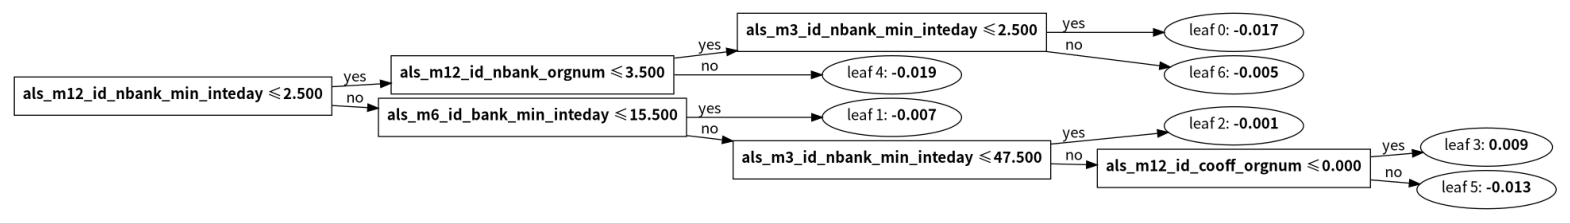

In [106]:
# example = train.iloc[763, :-4]
lgbm.plotting.plot_tree(clf, tree_index=5, figsize=(20, 20))

<AxesSubplot:>

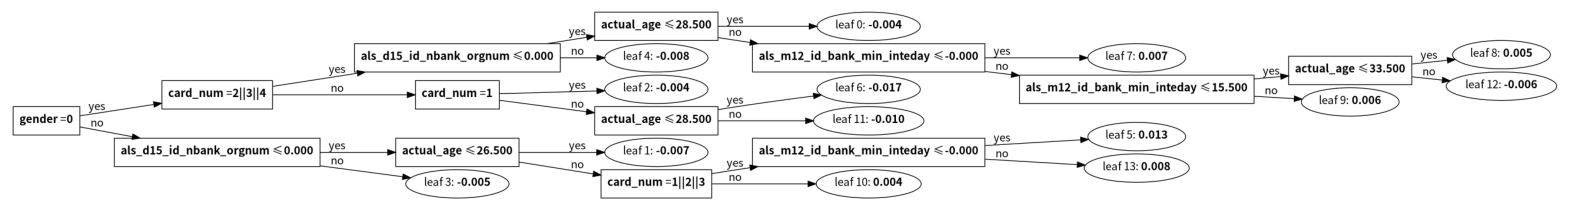

In [92]:
lgbm.plotting.plot_tree(clf, tree_index=1, figsize=(20, 20))

<AxesSubplot:>

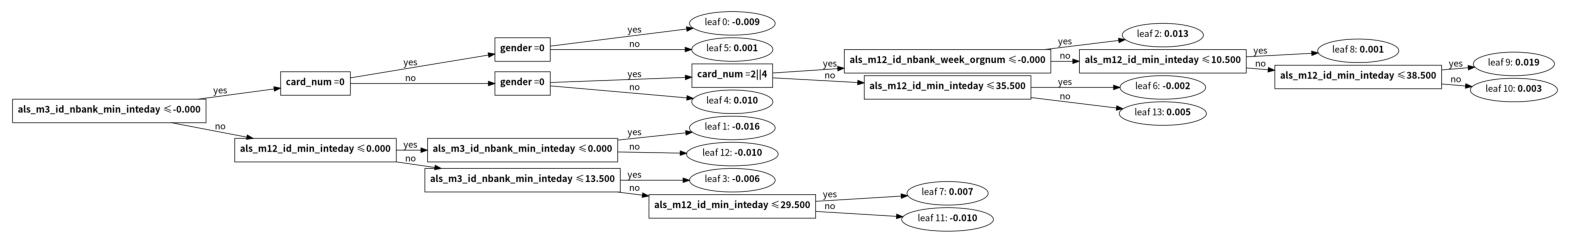

In [96]:
lgbm.plotting.plot_tree(clf, tree_index=5, figsize=(20, 20))